<a href="https://colab.research.google.com/github/jatin93-boop/Deep-Learning-Based-Multi-Modal-Data-Fusion-for-Precision-Agriculture-AgriFusion-Former-Framework/blob/main/Copy_of_Precision_Agriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Upload your dataset file
uploaded = files.upload()  # Choose Crop_recommendation.csv and real_time_sensor_data.csv

# Load the uploaded datasets
crop_df = pd.read_csv("Crop_recommendation.csv")
sensor_df = pd.read_csv("real_time_sensor_data.csv")

# Confirm loaded successfully
print("✅ Crop Data Loaded:", crop_df.shape)
print("✅ Sensor Data Loaded:", sensor_df.shape)

# Preview first few rows
print("\nCrop Dataset Preview:")
print(crop_df.head())

print("\nSensor Dataset Preview:")
print(sensor_df.head())


Saving real_time_sensor_data.csv to real_time_sensor_data.csv
Saving Crop_recommendation.csv to Crop_recommendation.csv
✅ Crop Data Loaded: (2200, 8)
✅ Sensor Data Loaded: (100, 7)

Crop Dataset Preview:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Sensor Dataset Preview:
     N    P    K  temperature  humidity    ph  rainfall
0  102  135  201        24.87     86.10  5.27    155.69
1   92    5   41        36.11     80.70  6.03    130.41
2   14    9  164        38.25     64.55  6.86    116.72
3  106  107   13        16.76     76.07  7.70    200.47
4   71   31  103        20.22     67.40  7.84    167.05


In [ ]:
# S1: Import Libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model


In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload Crop_recommendationV2.csv and real_time_sensor_data.csv


Saving real_time_sensor_data.csv to real_time_sensor_data (1).csv
Saving Crop_recommendation.csv to Crop_recommendation (1).csv


In [ ]:
# S2: Load Datasets
crop_df = pd.read_csv("Crop_recommendation.csv")
sensor_df = pd.read_csv("real_time_sensor_data.csv")


In [ ]:
## S3: Separate modalities

# Crop Feature Inputs
crop_features = ['N','P','K','temperature','humidity','ph','rainfall']
X_crop = crop_df[crop_features]

# Target Label
y = crop_df['label']

# Sensor Inputs (from real_time_sensor_data.csv)
# Use compatible column names
sensor_df = sensor_df.rename(columns={
    "temperature": "temperature_sensor",
    "humidity": "soil_moisture_sensor",
    "ph": "crop_health_sensor"
})

sensor_features = ['soil_moisture_sensor','temperature_sensor','crop_health_sensor']
X_sensor = sensor_df[sensor_features]



In [ ]:
# S4: Data Normalization & Label Encoding

# Equal length alignment
n = min(len(X_crop), len(X_sensor))
X_crop, X_sensor, y = X_crop[:n], X_sensor[:n], y[:n]

# Encode crop labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize
scaler = MinMaxScaler()
X_crop = scaler.fit_transform(X_crop)
X_sensor = scaler.fit_transform(X_sensor)


In [ ]:
# S5: Split data
Xc_train, Xc_test, Xs_train, Xs_test, y_train, y_test = train_test_split(
    X_crop, X_sensor, y_encoded, test_size=0.2, random_state=42
)


In [ ]:
# S6: Multimodal Fusion Model

# Branch 1: Crop Feature Encoder
input_crop = layers.Input(shape=(Xc_train.shape[1],), name="Crop_Input")
crop_branch = layers.Dense(128, activation='relu')(input_crop)
crop_branch = layers.BatchNormalization()(crop_branch)
crop_branch = layers.Dense(64, activation='relu')(crop_branch)

# Branch 2: Sensor Feature Encoder
input_sensor = layers.Input(shape=(Xs_train.shape[1],), name="Sensor_Input")
sensor_branch = layers.Dense(64, activation='relu')(input_sensor)
sensor_branch = layers.BatchNormalization()(sensor_branch)
sensor_branch = layers.Dense(32, activation='relu')(sensor_branch)

# Fusion Layer
fusion = layers.concatenate([crop_branch, sensor_branch], name="Fusion_Layer")
fusion = layers.Dense(128, activation='relu')(fusion)
fusion = layers.Dropout(0.3)(fusion)
output = layers.Dense(len(encoder.classes_), activation='softmax', name="Output")(fusion)

# Final Model
model = Model(inputs=[input_crop, input_sensor], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Crop_Input          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sensor_Input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,024 │ Crop_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        256 │ Sensor_Input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fusion_Layer        │ (None, 96)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     12,416 │ Fusion_Layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,929 (97.38 KB)

 Trainable params: 24,545 (95.88 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# S7: Train Model
history = model.fit([Xc_train, Xs_train], y_train,
                    validation_data=([Xc_test, Xs_test], y_test),
                    epochs=50, batch_size=16)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
5/5 ━━━━━━━━━

In [ ]:
# S8: Evaluate Model
loss, accuracy = model.evaluate([Xc_test, Xs_test], y_test)
print("✅ Final Model Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
✅ Final Model Accuracy: 0.0


In [ ]:
# Install graphviz if needed
!pip install graphviz

from graphviz import Digraph

# Create Digraph object
diagram = Digraph(format="png")
diagram.attr(rankdir="TB", size="8,10")

# Nodes
diagram.node("A", "Data Acquisition\n(Crop Dataset + Sensor Data)", shape="box", style="rounded,filled", fillcolor="#C9F5A6")
diagram.node("B", "Data Preprocessing\n(Normalization, Encoding, Alignment)", shape="box", style="rounded,filled", fillcolor="#FFE7A2")
diagram.node("C1", "Crop Feature Branch\nDense Layers", shape="box", style="rounded,filled", fillcolor="#A6D8FF")
diagram.node("C2", "Sensor Feature Branch\nDense Layers", shape="box", style="rounded,filled", fillcolor="#A6D8FF")
diagram.node("D", "Fusion Layer\n(Concatenate + Dense + Dropout)", shape="box", style="rounded,filled", fillcolor="#D7B4F3")
diagram.node("E", "Output Layer\n(Softmax Crop Prediction)", shape="box", style="rounded,filled", fillcolor="#FFB3B3")
diagram.node("F", "Recommended Crop", shape="box", style="rounded,filled", fillcolor="#B0FFDA")

# Edges
diagram.edge("A", "B")
diagram.edge("B", "C1")
diagram.edge("B", "C2")
diagram.edge("C1", "D")
diagram.edge("C2", "D")
diagram.edge("D", "E")
diagram.edge("E", "F")

# Render the diagram
diagram.render("precision_agriculture_block_diagram", view=True)


'precision_agriculture_block_diagram.png'

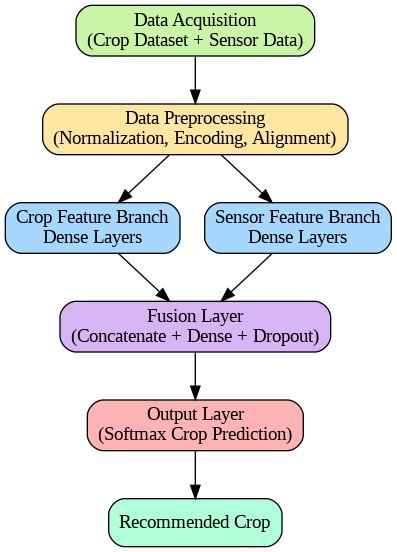

In [ ]:
from IPython.display import Image
Image(filename="precision_agriculture_block_diagram.png")
